# Freeswitch Log pyspark

## Altanai Bisht 
( abisht@seattleu.edu
altanai.telecom.com)

License GPL 3

In [2]:
import os 
os.environ['JAVA_HOME']="C:\\Users\\abisht\\.jdks\\corretto-11.0.15"
print(os.environ['JAVA_HOME'])

C:\Users\abisht\.jdks\corretto-11.0.15


In [3]:
import findspark
findspark.init()
findspark.find()

'C:\\Users\\abisht\\Downloads\\spark-3.2.1-bin-hadoop3.2\\spark-3.2.1-bin-hadoop3.2'

In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, date

%matplotlib inline

In [6]:
import pyspark 
from pyspark.sql import Row
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [7]:
from pyspark.mllib.stat import Statistics 
import re

# 1. Call Record

FreeSWITCH CDRs stored in /usr/local/freeswitch/log/cdr-csv/Master.csv
ref : https://freeswitch.org/confluence/display/FREESWITCH/CDR
and https://freeswitch.org/confluence/display/FREESWITCH/mod_cdr_csv

In [8]:
# logfile = "/fslogs/*.log"
# fslogs = sc.textFile("hdfs://localhost:9000/"+logfile)
filepath_csv= "C:\\Users\\abisht\\FS_logs\\*.csv"

from pyspark import SparkFiles
df = spark.read.csv(SparkFiles.get(filepath_csv), header=False, inferSchema= True)

In [9]:
parsed_df = df.select(df._c4, df._c6, df._c10)
parsed_df.head(5)

[Row(_c4='2020-06-13 00:58:52', _c6='2020-06-13 00:58:53', _c10='f2b05a36-ace2-11ea-aa3b-153da8caf925'),
 Row(_c4='2020-06-13 00:59:51', _c6='2020-06-13 00:59:52', _c10='15d78f5c-ace3-11ea-aa45-153da8caf925'),
 Row(_c4='2020-06-13 01:00:13', _c6='2020-06-13 01:00:14', _c10='22d77398-ace3-11ea-aa4f-153da8caf925'),
 Row(_c4='2020-06-13 01:00:36', _c6='2020-06-13 01:00:37', _c10='30e9979a-ace3-11ea-aa59-153da8caf925'),
 Row(_c4='2020-06-13 01:00:43', _c6='2020-06-13 01:00:44', _c10='35075b78-ace3-11ea-aa63-153da8caf925')]

In [13]:
new_rdd = parsed_df.rdd
parsed_rdd = new_rdd.map(lambda r : Row(\
                                        startTime =r[0],\
                                        endTime=r[1],\
                                        calluuid=r[-1]))
cdr_df = spark.createDataFrame(parsed_rdd)
cdr_df.show(5)

+-------------------+-------------------+--------------------+
|          startTime|            endTime|            calluuid|
+-------------------+-------------------+--------------------+
|2020-06-13 00:58:52|2020-06-13 00:58:53|f2b05a36-ace2-11e...|
|2020-06-13 00:59:51|2020-06-13 00:59:52|15d78f5c-ace3-11e...|
|2020-06-13 01:00:13|2020-06-13 01:00:14|22d77398-ace3-11e...|
|2020-06-13 01:00:36|2020-06-13 01:00:37|30e9979a-ace3-11e...|
|2020-06-13 01:00:43|2020-06-13 01:00:44|35075b78-ace3-11e...|
+-------------------+-------------------+--------------------+
only showing top 5 rows



In [14]:
cdr_df.printSchema()

root
 |-- startTime: string (nullable = true)
 |-- endTime: string (nullable = true)
 |-- calluuid: string (nullable = true)



In [15]:
cdr_df.show(1, vertical=True)

-RECORD 0-------------------------
 startTime | 2020-06-13 00:58:52  
 endTime   | 2020-06-13 00:58:53  
 calluuid  | f2b05a36-ace2-11e... 
only showing top 1 row



# 2. Freeswitch VoIP Logs


In [16]:
filepath_logs= "C:\\Users\\abisht\\VoIPCallLogs_BigDataSet\\freeswitch\\*.log"

from pyspark import SparkFiles
base_df = spark.read.text(SparkFiles.get(filepath_logs))
base_df.head()

Row(value='2020-06-14 05:05:07.622623 [NOTICE] mod_logfile.c:192 New log started: /usr/local/freeswitch/log/freeswitch.log')

In [17]:
base_df.show(10, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                          |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2020-06-14 05:05:07.622623 [NOTICE] mod_logfile.c:192 New log started: /usr/local/freeswitch/log/freeswitch.log                                                |
|2020-06-14 05:05:07.622623 [DEBUG] sofia_reg.c:1790 Send challenge for [9999@117.201.85.75]                                                                    |
|2020-06-14 05:05:07.622623 [WARNING] sofia_reg.c:1794 SIP auth challenge (REGISTER) on sofia profile 'internal' for [9999@117.201.85.75] from ip 37.187.153.237|
|send 618 bytes to udp/[37.1

In [18]:
print(base_df.columns)
type(base_df)

['value']


pyspark.sql.dataframe.DataFrame

## 2.1 Data Wrangling in Logs 

In [31]:
# sample_logs = [item['value'] for item in base_df.take(15)]
# sample_logs

## 2.2 Reframe the dataframe with regex

Extracting timestamps

In [20]:
from pyspark.sql.functions import regexp_extract

# 2020-06-14 05:05:07.622623
ts_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})'

logs_df = base_df.select(regexp_extract('value', ts_pattern, 1).alias('timestamp'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+-------------------+
|          timestamp|
+-------------------+
|2020-06-14 05:05:07|
|2020-06-14 05:05:07|
|2020-06-14 05:05:07|
|                   |
|                   |
|                   |
|                   |
|                   |
|                   |
|                   |
+-------------------+
only showing top 10 rows

(15039024, 1)


## 2.3 Finding missing values, Drop or values outside of date range 

In [21]:
dates = ("2015-01-01",  "2022-12-31")
# bad_rows_df = logs_df['timestamp'].between(*dates).show(truncate=False)
useful_logs_df= logs_df.select(logs_df['timestamp'], logs_df['timestamp'].between(*dates))
useful_logs_df.count()

15039024

In [22]:
logs_df = useful_logs_df[useful_logs_df[1]=='true']
logs_df.show(10, truncate=True)

+-------------------+---------------------------------------------------------+
|          timestamp|((timestamp >= 2015-01-01) AND (timestamp <= 2022-12-31))|
+-------------------+---------------------------------------------------------+
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                                                     true|
|2020-06-14 05:05:07|                   

# 3. Call Recorded Audio File 

- wav

In [23]:
import scipy
import os.path, time, datetime
import platform

In [24]:
audiopath= 'C:\\Users\\abisht\\VoIPCallLogs_BigDataSet\\audiofiles'

In [25]:
base_list_audio = []
for file in os.listdir(audiopath):
    # base_df.append(datetime.datetime.fromtimestamp(os.stat(os.path.join(audiopath,file)).st_mtime).timestamp())
    base_list_audio.append(datetime.datetime.fromtimestamp(os.stat(os.path.join(audiopath,file)).st_mtime))
base_list_audio

[datetime.datetime(2022, 6, 2, 16, 14, 8, 138912),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 156902),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 174819),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 194669),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 213619),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 232080),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 252002),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 271010),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 289884),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 313184),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 333964),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 352916),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 372862),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 394068),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 419735),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 442286),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 461651),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 481605),
 datetime.datetime(2022, 6, 2, 16, 14, 8, 502514),
 datetime.datetime(2022, 6, 2, 

## 3.1 Data Wrangling

In [26]:
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType

audio_df = spark.createDataFrame(base_list_audio,TimestampType())
audio_df = audio_df.select(col("value").alias("timestamp"))
audio_df.show()

+--------------------+
|           timestamp|
+--------------------+
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
|2022-06-02 16:14:...|
+--------------------+
only showing top 20 rows



## 3.2 Finding missing values, Drop or values outside of date range 

In [27]:
dates = ("2015-01-01",  "2022-12-31")
# bad_rows_df = logs_df['timestamp'].between(*dates).show(truncate=False)
useful_audio_df= audio_df.select(audio_df['timestamp'], audio_df['timestamp'].between(*dates))
useful_audio_df.count()

954

# 4.RDD row to spark dataframe

In [28]:
cdr_rdd = cdr_df.rdd
parsed_rdd = cdr_rdd.map(lambda r : Row(\
                                        startTime =r[0],\
                                        endTime=r[0],\
                                        calluuid=r[0]))
df_cdr = spark.createDataFrame(parsed_rdd)
print(df_cdr.count())
df_cdr.printSchema()

43854
root
 |-- startTime: string (nullable = true)
 |-- endTime: string (nullable = true)
 |-- calluuid: string (nullable = true)



In [29]:
new_rdd = logs_df.rdd
parsed_rdd = new_rdd.map(lambda r : Row(\
                                        startTime =r[0],\
                                        endTime=r[0],\
                                        calluuid=r[0]))
df_log = spark.createDataFrame(parsed_rdd)
print(df_log.count())
df_log.printSchema()

1923550
root
 |-- startTime: string (nullable = true)
 |-- endTime: string (nullable = true)
 |-- calluuid: string (nullable = true)



In [30]:
audio_rdd = useful_audio_df.rdd
parsed_audio_rdd = audio_rdd.map(lambda r : Row(\
                                        startTime =r[0],\
                                        endTime=r[0],\
                                        calluuid=r[0]))
df_audio = spark.createDataFrame(parsed_audio_rdd)
print(df_audio.count())
df_audio.printSchema()

954
root
 |-- startTime: timestamp (nullable = true)
 |-- endTime: timestamp (nullable = true)
 |-- calluuid: timestamp (nullable = true)



## 4.1 Combine all dataframe 

In [32]:
df = df_log.union(df_cdr).union(df_audio)
print(df.count)
df.show()

<bound method DataFrame.count of DataFrame[startTime: string, endTime: string, calluuid: string]>
+-------------------+-------------------+-------------------+
|          startTime|            endTime|           calluuid|
+-------------------+-------------------+-------------------+
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05:05:07|2020-06-14 05:05:07|
|2020-06-14 05:05:07|2020-06-14 05

# 5. Daily - Request reponse network traffic 

In [33]:
from pyspark.sql import functions as F

# find the day of the month
daily_traffic_df = df.select(df['startTime'], F.dayofmonth('startTime').alias('day'))
daily_traffic_df.show(5, truncate=False)

+-------------------+---+
|startTime          |day|
+-------------------+---+
|2020-06-14 05:05:07|14 |
|2020-06-14 05:05:07|14 |
|2020-06-14 05:05:07|14 |
|2020-06-14 05:05:07|14 |
|2020-06-14 05:05:07|14 |
+-------------------+---+
only showing top 5 rows



In [34]:
# Count of calls per day
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_df = (daily_traffic_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_df = daily_df.toPandas()
daily_df

,day,count
0,NaN,21888
1,2.0,35115
2,5.0,219
3,13.0,18104
4,14.0,1783364
...,...,...
11,26.0,2528
12,27.0,2536
13,28.0,1856
14,30.0,218


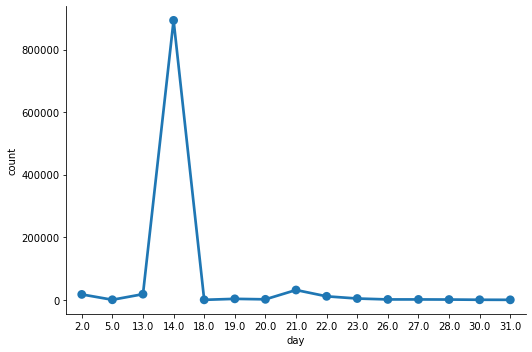

In [58]:
c = sns.catplot(x='day', y='count',
                data=daily_df,
                kind='point', height=5,
                aspect=1.5)

# 6. Hourly - Request reponse network traffic 

In [35]:
# Count of calls per hour

from pyspark.sql.functions import col, count, date_format, date_sub, date_trunc, month, next_day, to_timestamp, weekofyear, window, year

def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

hourly_df = (daily_traffic_df
                     .select(F.date_format('startTime','yyyy-MM-dd hh:mm:ss').alias('timestamp'))
                     .groupBy(window('timestamp', "15 minutes"))
                     .count())
# hourly_df= hourly_df.groupBy('startTime', window('startTime', "5 minutes")).sum("metric")

hourly_df = hourly_df.toPandas()
hourly_df

,window,count
0,"(2020-06-14 05:15:00, 2020-06-14 05:30:00)",390898
1,"(2020-06-14 05:00:00, 2020-06-14 05:15:00)",288794
2,"(2020-06-14 05:30:00, 2020-06-14 05:45:00)",74351
3,"(2020-06-14 06:30:00, 2020-06-14 06:45:00)",66537
4,"(2020-06-14 07:15:00, 2020-06-14 07:30:00)",73128
...,...,...
196,"(2022-05-31 08:30:00, 2022-05-31 08:45:00)",3
197,"(2022-05-31 09:00:00, 2022-05-31 09:15:00)",1
198,"(2022-05-31 06:30:00, 2022-05-31 06:45:00)",2
199,"(2022-06-02 03:45:00, 2022-06-02 04:00:00)",2


In [36]:
window_start = hourly_df['window'].map(lambda r : Row(start =r[0]))
window_start= spark.createDataFrame(window_start).toPandas()
hourly_df["start"]=window_start
hourly_df.drop(columns=["window"], inplace=True)
hourly_df

,count,start
0,390898,2020-06-14 05:15:00
1,288794,2020-06-14 05:00:00
2,74351,2020-06-14 05:30:00
3,66537,2020-06-14 06:30:00
4,73128,2020-06-14 07:15:00
...,...,...
196,3,2022-05-31 08:30:00
197,1,2022-05-31 09:00:00
198,2,2022-05-31 06:30:00
199,2,2022-06-02 03:45:00


<Figure size 432x360 with 0 Axes>

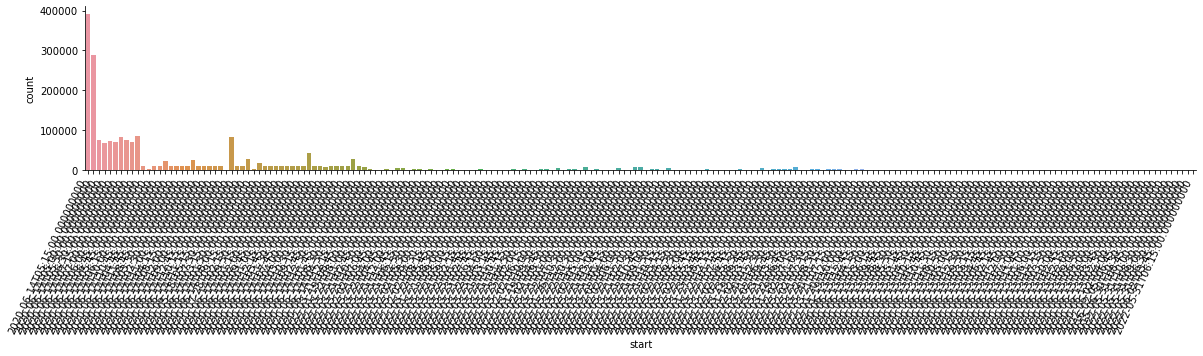

In [37]:
plt.figure(figsize=(6,5))
chart = sns.catplot(x='start', y='count',
                data=hourly_df,
                kind='bar', height=3, aspect=6)
chart.set_xticklabels(rotation=65, horizontalalignment='right')

## Yearly

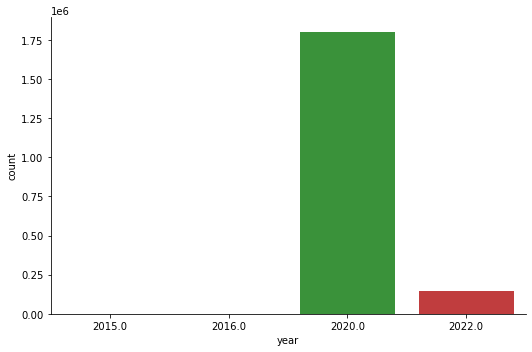

In [38]:
year_callduration_df = (df
                       .groupBy(F.year('startTime').alias('year'))
                       .count()
                       .sort('year'))
year_callduration_pd_df = year_callduration_df.toPandas()

c = sns.catplot(x='year', y='count',
                data=year_callduration_pd_df,
                kind='bar', height=5, aspect=1.5)

# 7. Energy consumption  and Carbon Footprint

In [39]:
from carbonfootprint.carbon import Carbon
from carbonfootprint.fuelmix import Fuelmix
# furlpercent_obj = carbonfp.power_utilities.Fuelmix("north_west")

In [40]:
column_list = ("Wind", "Solar",  "Hydro",  "Other", "Petroleum",  "Natural gas", "Coal", "Nuclear",  "Battery", "Imports")
column_list_carbon = [ "carbon_"+sub + "(kgeCO2)" for sub in column_list]

## 7.1 Energy consumption 

In [41]:
hourly_df["energyConsumption(kWh)"] = hourly_df["count"]*0.4
hourly_df["power(W)"]= hourly_df["energyConsumption(kWh)"]/60
hourly_df.head()

,count,start,energyConsumption(kWh),power(W)
0,390898,2020-06-14 05:15:00,156359.2,2605.986667
1,288794,2020-06-14 05:00:00,115517.6,1925.293333
2,74351,2020-06-14 05:30:00,29740.4,495.673333
3,66537,2020-06-14 06:30:00,26614.8,443.580000
4,73128,2020-06-14 07:15:00,29251.2,487.520000


In [42]:
region ="north_west"
furlpercent_obj = Fuelmix(region)
df_hourly_fuelmix = furlpercent_obj.calculate_fuelmixbypercent(hourly_df)

    count               start  energyConsumption(kWh)     power(W)
0  390898 2020-06-14 05:15:00                156359.2  2605.986667
1  288794 2020-06-14 05:00:00                115517.6  1925.293333
2   74351 2020-06-14 05:30:00                 29740.4   495.673333
3   66537 2020-06-14 06:30:00                 26614.8   443.580000
4   73128 2020-06-14 07:15:00                 29251.2   487.520000
utility_fuelmix filenames C:\Users\abisht\Anaconda3\lib\site-packages\carbonfootprint\dataset/north_west2020/*.csv
  Region Code Timestamp (Hour Ending)  Wind Generation (MWh)  \
0          NW    1/1/2020 12 a.m. PST                   7689   
1          NW     1/1/2020 1 a.m. PST                   7751   
2          NW     1/1/2020 2 a.m. PST                   7269   
3          NW     1/1/2020 3 a.m. PST                   6892   
4          NW     1/1/2020 4 a.m. PST                   6526   

   Solar Generation (MWh)  Hydro Generation (MWh)  Other Generation (MWh)  \
0                    

## 7.2 Carbon Emission 

In [43]:
carbonemissio_pbj = Carbon()
hourly_fuelmix_carbon = carbonemissio_pbj.calculate_carbonemission(df_hourly_fuelmix)
hourly_fuelmix_carbon.head()

,count,start,energyConsumption(kWh),power(W),Wind(W),Solar(W),Hydro(W),Other(W),Petroleum(W),Natural gas(W),...,carbon_Solar(kgeCO2),carbon_Hydro(kgeCO2),carbon_Other(kgeCO2),carbon_Petroleum(kgeCO2),carbon_Natural gas(kgeCO2),carbon_Coal(kgeCO2),carbon_Nuclear(kgeCO2),carbon_Battery(kgeCO2),carbon_Imports(kgeCO2),carbon_total(kgeCO2)
0,390898,2020-06-14 05:15:00,156359.2,2605.986667,506.814839,-0.065914,616.166617,66.771158,3.954856,568.642426,...,-3.163885e-06,0.014788,0.001603,0.001938,0.278635,0.629679,0.000910,0.0,0.0,0.933630
1,288794,2020-06-14 05:00:00,115517.6,1925.293333,384.860055,-0.099306,442.904359,51.887338,2.979177,425.823743,...,-4.766684e-06,0.010630,0.001245,0.001460,0.208654,0.458985,0.000686,0.0,0.0,0.686273
2,74351,2020-06-14 05:30:00,29740.4,495.673333,95.082321,0.013081,112.361691,13.904596,0.771751,112.727946,...,6.278651e-07,0.002697,0.000334,0.000378,0.055237,0.119509,0.000181,0.0,0.0,0.179477
3,66537,2020-06-14 06:30:00,26614.8,443.580000,81.456752,0.000000,105.673944,12.374524,0.709142,101.962768,...,0.000000e+00,0.002536,0.000297,0.000347,0.049962,0.104815,0.000163,0.0,0.0,0.159098
4,73128,2020-06-14 07:15:00,29251.2,487.520000,85.355892,-0.013079,114.823686,13.641771,0.771682,114.418226,...,-6.278092e-07,0.002756,0.000327,0.000378,0.056065,0.117686,0.000180,0.0,0.0,0.178416


Text(0, 0.5, 'Carbon Emission (kgCO2eq)')

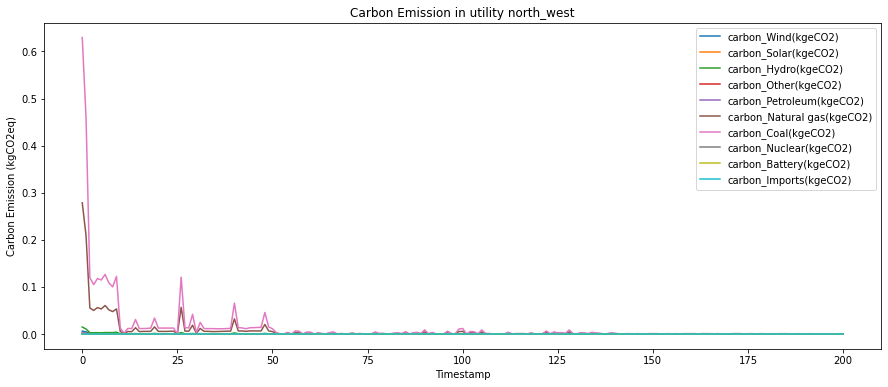

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
hourly_fuelmix_carbon.plot( 
    # x = "DateTime24",
    y = np.array(column_list_carbon),
    title = "Carbon Emission in utility "+ region ,
    ax=ax) 

ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission (kgCO2eq)")

## CAISO

    count               start  energyConsumption(kWh)     power(W)  \
0  390898 2020-06-14 05:15:00                156359.2  2605.986667   
1  288794 2020-06-14 05:00:00                115517.6  1925.293333   
2   74351 2020-06-14 05:30:00                 29740.4   495.673333   
3   66537 2020-06-14 06:30:00                 26614.8   443.580000   
4   73128 2020-06-14 07:15:00                 29251.2   487.520000   

      Wind(W)  Solar(W)    Hydro(W)   Other(W)  Petroleum(W)  Natural gas(W)  \
0  506.814839 -0.065914  616.166617  66.771158      3.954856      568.642426   
1  384.860055 -0.099306  442.904359  51.887338      2.979177      425.823743   
2   95.082321  0.013081  112.361691  13.904596      0.771751      112.727946   
3   81.456752  0.000000  105.673944  12.374524      0.709142      101.962768   
4   85.355892 -0.013079  114.823686  13.641771      0.771682      114.418226   

   ...  carbon_Solar(kgeCO2)  carbon_Hydro(kgeCO2)  carbon_Other(kgeCO2)  \
0  ...         -3.1638

Text(0, 0.5, 'Carbon Emission (kgCO2eq)')

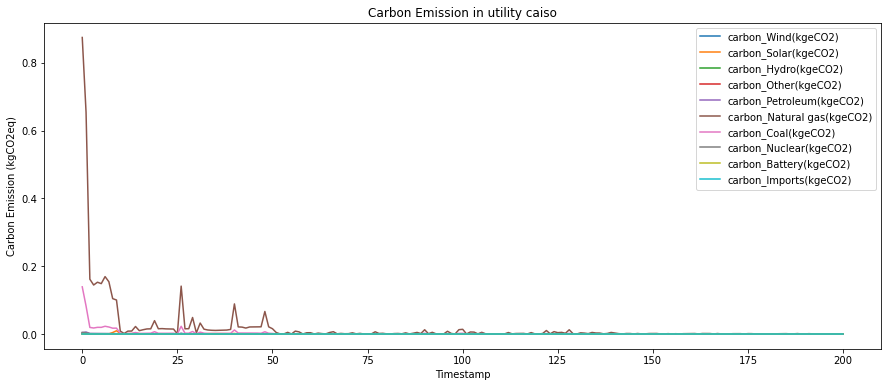

In [45]:
region ="caiso"
furlpercent_obj = Fuelmix(region)
df_hourly_fuelmix = furlpercent_obj.calculate_fuelmixbypercent(hourly_df)

carbonemissio_pbj = Carbon()
hourly_fuelmix_carbon = carbonemissio_pbj.calculate_carbonemission(df_hourly_fuelmix)

fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
hourly_fuelmix_carbon.plot( 
    # x = "DateTime24",
    y = np.array(column_list_carbon),
    title = "Carbon Emission in utility "+ region ,
    ax=ax) 

ax.set_xlabel("Timestamp")
ax.set_ylabel("Carbon Emission (kgCO2eq)")

**Refs**
- https://opensource.com/article/19/5/visualize-log-data-apache-spark
- http://www-mmsp.ece.mcgill.ca/Documents/AudioFormats/WAVE/Samples.html
-https://towardsdatascience.com/40-open-source-audio-datasets-for-ml-59dc39d48f06
- https://opensource.com/article/19/5/visualize-log-data-apache-spark